In [67]:
# Built-in modules
import os
import sys
import time
import statistics
from dataclasses import dataclass

# External modules
import scipy
import numpy as np
import pandas as pd
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Pastel1
from tqdm import tqdm

# Local modules
from Window import Window
from Mapper import Mapper
import Trace
import PhaseDetector

In [68]:
TRACES = Trace.TraceList('parrot-traces/test-traces/', new_ext=True)

In [70]:
TRACES.load()

In [71]:
def summarize(arr, s):
    nint = len(arr) // s
    return [np.mean(arr[i*s : (i+1)*s]) for i in range(nint)]

def make_plot(ax, tr1, tr2, params):
    lat1 = summarize(tr1.data['latency_nano'], params.summarize)
    lat2 = summarize(tr2.data['latency_nano'], params.summarize)
    
    print(len(lat1))
    print(len(lat2))
    
    ax.plot(lat1, color='blue', label=tr1.name)
    ax.plot(lat2, color='black', label=tr2.name)
    
    ax.axvline(params.rr_start/params.summarize, color='red', label='RR')
    ax.axvline(params.rr_end/params.summarize, color='red')
    
    ax.set_xlabel(f"Inteval ({params.summarize}'s of instructions)")
    ax.set_ylabel(f"Mean Latency")
    
    
def super_plot(tr1, tr2, params):
    fig, ax = plt.subplots(constrained_layout=True)
    
    make_plot(ax, tr1, tr2, params)
    
    fig.legend()
    
    if params.savefig:
        fig.savefig('plots/2mm-mf-vs-normal-debug.png')

95
58


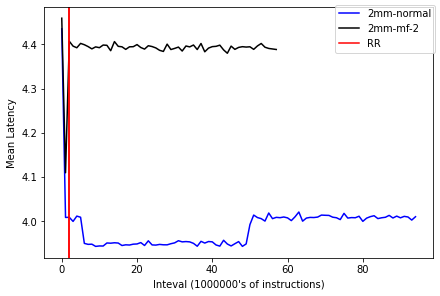

In [72]:
@dataclass(frozen=True)
class Param:
    summarize: int = 1_000_000
    savefig: bool = False
    rr_start: int = 1856000
    rr_end: int = 1856000+79000

super_plot(TRACES[2], TRACES[1], Param())

In [63]:
# Display the mean of the accesses contained in the RR
# We know the RR from the file for the mf run
# We know the RR from the optimizer for the normal run
# They are the same somehow? Incredible

def region_mean(trace, start, end):
    print(f'Mean [{trace.name}]:  \t{np.mean(trace.data["latency_nano"][start:end]):.3f}')

region_mean(TRACES[0], 1856000, 1856000+79000)
region_mean(TRACES[1], 1856000,  1856000+79000)

Mean m-mf]:  	3.949
Mean m-normal]:  	3.985


Ok, so the mean is about right. 3.9. That's where the black line is above. Why aren't we getting the same behavior out of the MF model?

Our mean latency is too low. That should translate into an IPC that is too high. However, we are getting an IPC that is actually too low. 

That's not good. But let's focus on fixing the latency first.